# Traffic sign recognition

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

tf.enable_eager_execution()
# Make the plots larger
plt.rcParams["figure.figsize"] = (10,10)

## Read training data

There are 43 classes with images of different dimensions. The images are stored in directories that correspond to their class names. Due to their varying dimensions, the images have to be resized.

In [2]:
# Training dataframe
train_frame = pd.read_csv('data/Train.csv')

# Training images and labels
train_imgs = []
train_labels = []

# Common image size
height = 30
width = 30

for index, row in train_frame.iterrows():
    img = Image.open('data/' + row['Path'])
    resized_img = img.resize((height, width))
    np_img = np.array(resized_img)
    train_imgs.append(np_img)
    train_labels.append(row['ClassId'])

In [3]:
# Sanity checks
print(len(train_imgs))
print(len(train_labels))
print(train_imgs[100].shape)

# Convert lists to numpy arrays
train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)

print(train_imgs.shape)
print(train_labels.shape)

# Normalize pixel data to 0-1 range
train_imgs = train_imgs / 255

39209
39209
(30, 30, 3)
(39209, 30, 30, 3)
(39209,)


## Train/validation split

In [4]:
# Randomize order of images to obtain uniform distribution of samples accross both train and val.
indices = np.arange(train_imgs.shape[0])
np.random.seed(3746)
np.random.shuffle(indices)
train_imgs = train_imgs[indices]
train_labels = train_labels[indices]

print(train_imgs.shape)
print(train_labels.shape)

(39209, 30, 30, 3)
(39209,)


In [5]:
# Find cutoff for 80/20 train/val split
cutoff_index = (int) (0.2*train_imgs.shape[0])

x_train = train_imgs[cutoff_index:]
x_val = train_imgs[:cutoff_index]
# Convert labels from class indices to one-hot encoding (in order to use categorical crossentropy)
y_train = train_labels[cutoff_index:]
y_val = train_labels[:cutoff_index]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(31368, 30, 30, 3)
(7841, 30, 30, 3)
(31368,)
(7841,)


## Model definition

In [6]:
model = models.Sequential([
    layers.Conv2D(32, (5,5), activation='relu', input_shape=(height, width, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(43, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

In [7]:
#Compilation of the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    optimizer='adam', 
    metrics=['accuracy']
)

history = model.fit(x_train, y_train, batch_size=32, epochs=5, 
                    validation_data=(x_val, y_val))

Train on 31368 samples, validate on 7841 samples
Epoch 1/5
31368/31368 [==============================] - 65s 2ms/sample - loss: 1.4320 - acc: 0.5927 - val_loss: 0.1619 - val_acc: 0.9602
Epoch 2/5
31368/31368 [==============================] - 57s 2ms/sample - loss: 0.2465 - acc: 0.9260 - val_loss: 0.0745 - val_acc: 0.9838
Epoch 3/5
31368/31368 [==============================] - 56s 2ms/sample - loss: 0.1464 - acc: 0.9564 - val_loss: 0.0401 - val_acc: 0.9892
Epoch 4/5
31368/31368 [==============================] - 63s 2ms/sample - loss: 0.1039 - acc: 0.9687 - val_loss: 0.0290 - val_acc: 0.9936
Epoch 5/5
31368/31368 [==============================] - 63s 2ms/sample - loss: 0.0820 - acc: 0.9750 - val_loss: 0.0333 - val_acc: 0.9920


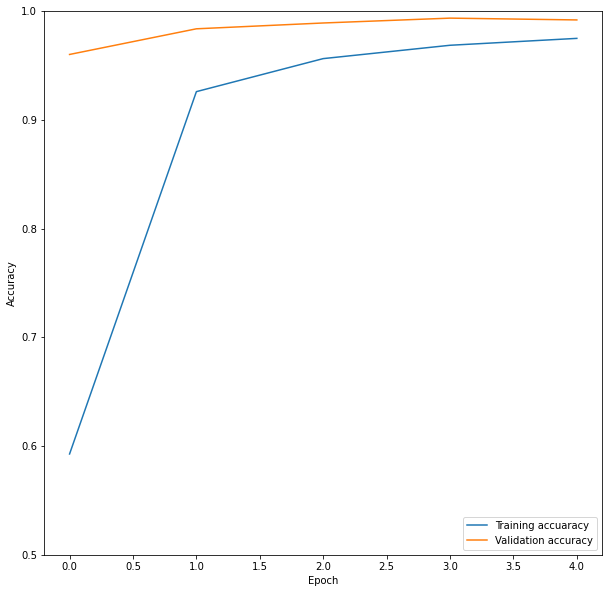

In [8]:
plt.plot(history.history['acc'], label='Training accuaracy')
plt.plot(history.history['val_acc'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Evaluate on testing data

In [10]:
# Testing dataframe
test_frame = pd.read_csv('data/Test.csv')

# Training images and labels
test_imgs = []
test_labels = []

for index, row in test_frame.iterrows():
    img = Image.open('data/' + row['Path'])
    resized_img = img.resize((height, width))
    np_img = np.array(resized_img)
    test_imgs.append(np_img)
    test_labels.append(row['ClassId'])

test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

# Normalize pixel data to 0-1 range
test_imgs = test_imgs / 255

print(test_imgs.shape)
print(test_labels.shape)

(12630, 30, 30, 3)
(12630,)


In [11]:
test_loss, test_acc = model.evaluate(test_imgs,  test_labels, verbose=2)

print(test_acc)

12630/1 - 5s - loss: 0.2236 - acc: 0.9616
0.96159935


In [12]:
# Compare predictions to reference images

meta_frame = pd.read_csv('data/Meta.csv')
ref_dict = {}

for index, row in meta_frame.iterrows():
    img = Image.open('data/' + row['Path'])
    ref_dict[row['ClassId']] = img

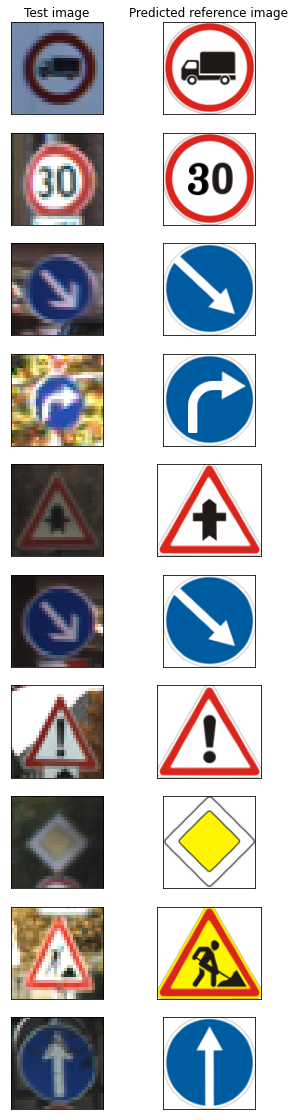

In [13]:
sample_size = 10

softmax_predictions = model.predict(test_imgs[:sample_size])
#softmax_predictions = tf.nn.softmax(predictions)

fig, axs = plt.subplots(sample_size, 2, figsize=(5, sample_size*2))

axs[0,0].annotate("Test image", xy=(0.5, 1), xytext=(0, 5),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline')
axs[0,1].annotate("Predicted reference image", xy=(0.5, 1), xytext=(0, 5),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline')


for i in range(sample_size):
    ax = axs[i, 0]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(test_imgs[i], cmap=plt.cm.binary)
    
    # take argmax of softmax_predictions[i]
    class_id = np.argmax(softmax_predictions[i])
    
    ax = axs[i, 1]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(ref_dict[class_id], cmap=plt.cm.binary)
plt.show()


## Save model

In [15]:
model.save('./model_test/keras_model.h5')

In [26]:
import time
times = []
for i in range(30):
    start = time.time()
    model.predict(np.expand_dims(test_imgs[i], axis=0))
    end = time.time()
    t = end - start
    times.append(t)

t_avg = np.mean(times)
t_std = np.std(times)
print(f"average inference time per image: {t_avg*1000}ms +/- {3*t_std*1000}ms")
np.savetxt("own_model_times_laptop.csv", times, delimiter=',')


average inference time per image: 73.43463897705078ms +/- 88.43898957256563ms
